In [1]:
from truss_FEM import *
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

from tqdm import *

# Create Design Space

The design space for this problem is a truss with 2 degrees of freedom: the height of the top two bars (y) and the distance of each of the top two points from the edge pins (x). 

While it is fairly easy to compute the optimal value in this design space, when the number of degrees of freedom are increased, the computational intensity increases greatly. This experiment is a test to see if surrogate modelling can successfully reproduce these design gradients with the intent to be able to quickly train them for larger, less manageable models.

(-1, 4)

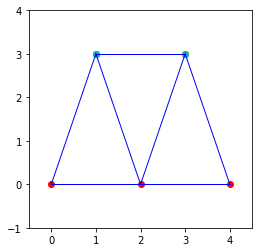

In [2]:
# Parameters
L=4
P = -100
Pdf = 9
s = 50

# Structure Geometry
nodes = np.zeros((5, 2))
nodes[0] = [0, 0]
nodes[3] = [L, 0]
nodes[4] = [L/2, 0]

members = np.array([[0, 1], [1, 2], [2, 3], [0, 4], [4, 3], [1, 4], [4, 2]])

# boundary conditions
u0 = [0, 0, 0, 0]
i0 = [0, 1, 6, 7]

# Parameters
x_range = [.1, 1.9]
y_range = [-5, 5]

fig, ax = plt.subplots(figsize=(4, 4))
nodes[1] = [1, 3]
nodes[2] = [L-1, 3]
plot_truss(nodes, members, ax=ax)
ax.scatter(nodes[[1, 2], 0], nodes[[1, 2], 1], c='c')
ax.set_xlim([-.5, 4.5])
ax.set_ylim([-1, 4])

In [3]:
# Discretize system
dx = 100
X_arr = np.linspace(x_range[0], x_range[1], dx)
Y_arr = np.linspace(y_range[0], y_range[1], dx)

# Create grid for ploting
Xgrid = np.zeros((X_arr.shape[0], Y_arr.shape[0]))
Ygrid = np.zeros((X_arr.shape[0], Y_arr.shape[0]))

In [4]:
Grad_control = np.zeros((len(X_arr), len(Y_arr)))
for i in range(len(X_arr)):
    for j in range(len(Y_arr)):
        x = X_arr[i]
        y = Y_arr[j]
        
        Xgrid[i, j] = x
        Ygrid[i, j] = y
        
        # avoid impossible cases
        if y==0:
            y = 0.001
        
        # Assign values to free nodes
        nodes[1] = [x, y]
        nodes[2] = [L-x, y]
        
        # compute displacements (u), internal forces (f), and member lengths (l) using direct stiffness method
        u, f, l = DSM(nodes, members, P=P, Pdf=Pdf, u0=u0, i0=i0)
        
        W = abs(f)/s @ np.array(l)
        Grad_control[i, j] = W

Optimial Position: 
	x = 1.5
	y = -1.3636363636363638
	Weight = 10.587878787878783


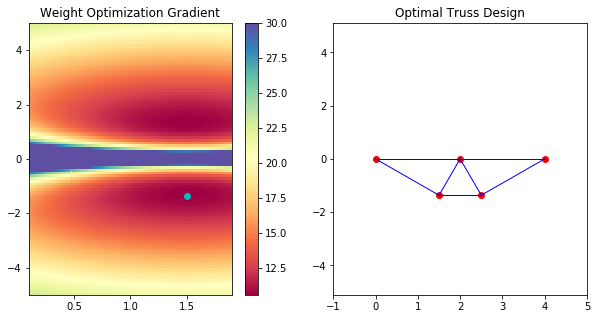

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

grad_plot = ax0.pcolormesh(Xgrid, Ygrid, Grad_control, vmax=30, cmap='Spectral')
ax0.set_title('Weight Optimization Gradient')

W_opt = np.min(Grad_control)
i_opt = np.where(Grad_control==W_opt)
ax0.scatter(Xgrid[i_opt[0], i_opt[1]], Ygrid[i_opt[0], i_opt[1]], c='c')

nodes[1] = [Xgrid[i_opt[0], i_opt[1]], Ygrid[i_opt[0], i_opt[1]]]
nodes[2] = [L-Xgrid[i_opt[0], i_opt[1]], Ygrid[i_opt[0], i_opt[1]]]
plot_truss(nodes, members, ax=ax1)
ax1.set_xlim([-1, 5])
ax1.set_ylim([-5.1, 5.1])
ax1.set_title('Optimal Truss Design')

fig.colorbar(grad_plot, ax=ax0)

print('Optimial Position: ')
print('\tx = ' + str(Xgrid[i_opt[0], i_opt[1]][0]))
print('\ty = ' + str(Ygrid[i_opt[0], i_opt[1]][0]))
print('\tWeight = ' + str(W_opt))

# Sample Design Space

Text(0.5, 1.0, 'Sampling of Design Space')

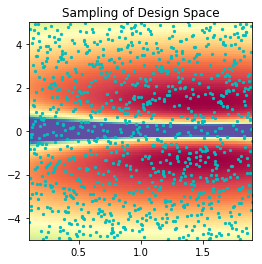

In [6]:
# Sample
X_lim = np.array([x_range, y_range])
samp = LHS(xlimits=X_lim)

#(x=0, y=1)
D = 1000
X = samp(D)

plt.figure(figsize=(4, 4))
plt.pcolormesh(Xgrid, Ygrid, Grad_control, cmap='Spectral', vmax=30, alpha=1)
plt.scatter(X[:, 0], X[:, 1], c='c', s=5)
plt.xlim(x_range)
plt.ylim(y_range)
plt.title('Sampling of Design Space')

In [7]:
Grad = np.zeros(X.shape[0])

for i in range(D):
    x = X[i, 0]
    y = X[i, 1]
    
    if y==0:
        y = 0.001
        
    nodes[1] = [x, y]
    nodes[2] = [L-x, y]
    
    u, f, l = DSM(nodes, members, P=P, Pdf=Pdf, u0=u0, i0=i0, A=10, E=100)
    
    W = abs(f)/s @ np.array(l)
    
    Grad[i] = W

In [8]:
# Get gradient as data label
Y = Grad.reshape(D, 1)

# Normalize
x_norm = (X - np.array([x_range[0], y_range[0]]))/np.array([x_range[1]-x_range[0], y_range[1]-y_range[0]])
y_norm = np.log(Y) - np.floor(np.min(np.log(Y)))

# Split the data into training data + testing data
X_train, X_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.1)
(X_train, X_test, y_train, y_test) = (torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_train).float(), torch.from_numpy(y_test).float())
dataset = TensorDataset(X_train,y_train)

# Batch
B = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=B, shuffle=True)

# Neural Network Architecture

In [9]:
class Net(nn.Module):
    
    # Network consruction
    def __init__(self, in_dim, ngpu=1):
        super(Net, self).__init__()
        self.ngpu = ngpu
        
       # Linear layers
        self.main = nn.Sequential(
            nn.Linear(in_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
       
        
    def forward(self, x):
        return self.main(x)

# Neural Network Training

In [10]:
model = Net(X.shape[1])

# Loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# Optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
epochs = 1000
error = []
it = []

for i in tqdm(range(epochs)):
    for data in dataloader:
        x_tr = data[0]
        y_tr = data[1]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x_tr)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_tr)

    #y_pred = model(X_train)
    #loss = loss_fn(y_pred, y_train)

        # optimize the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    if i%20 == 19:
        it.append(i)
        error.append(loss.item())


model.eval()

100%|██████████| 1000/1000 [01:12<00:00, 14.21it/s]


Net(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=1, bias=True)
  )
)

Text(0.5, 1.0, 'Accuracy of Results')

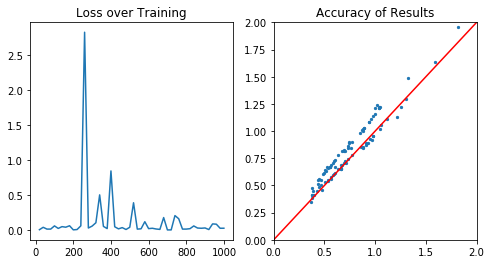

In [15]:
# Asses testing data
y_net = model(X_test)

# Plot Results of Neural Network
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

ax0.plot(it, error)
ax0.set_title('Loss over Training')

ax1.scatter(y_test.numpy(), y_net.detach().numpy(), s=5)
ax1.plot([0, 2], [0, 2], color='r')
ax1.set_xlim([0, 2])
ax1.set_ylim([0, 2])
ax1.set_title('Accuracy of Results')

Approximate Design: 		 10.401234
Actual Weight Approx. Design:	 10.74540535792709
Actual Optimum:			 10.587878787878783


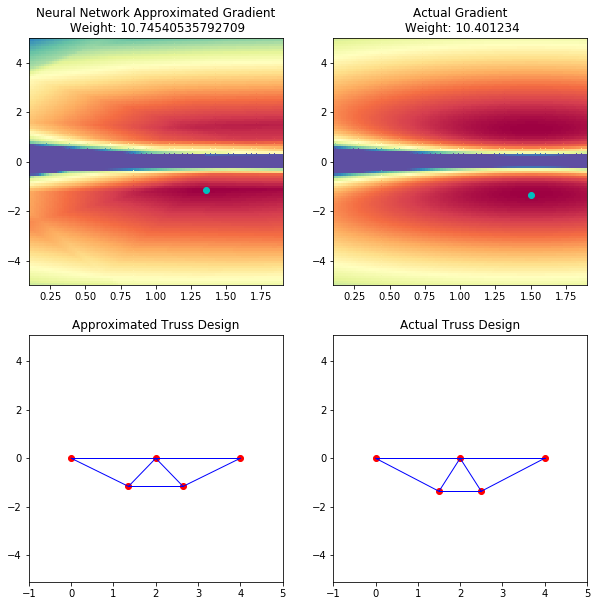

In [23]:
# Get X tensor for all points in the gradient
x0_test = Xgrid.reshape((Xgrid.shape[0]*Xgrid.shape[1], 1))
x1_test = Ygrid.reshape((Ygrid.shape[0]*Ygrid.shape[1], 1))
x_test = np.concatenate((x0_test, x1_test), axis=1)
X_norm = (x_test - np.array([x_range[0], y_range[0]]))/np.array([x_range[1]-x_range[0], y_range[1]-y_range[0]])
X_map = torch.from_numpy(X_norm).float()

# Get neural network's approximation of gradient
y_net = np.exp(model(X_map).detach().numpy() + np.floor(np.min(np.log(Y))))
Grad_net = y_net.reshape((Xgrid.shape[0], Xgrid.shape[1]))

# Get optimal point
W_apx = np.min(Grad_net)
i_apx = np.where(Grad_net==W_apx)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].pcolormesh(Xgrid, Ygrid, Grad_net, cmap='Spectral', vmax=30)
ax[0, 0].scatter(Xgrid[i_apx[0], i_apx[1]], Ygrid[i_apx[0], i_apx[1]], c='c')
ax[0, 0].set_xlim([x_range[0], x_range[1]])
ax[0, 0].set_ylim([y_range[0], y_range[1]])
ax[0, 0].set_title('Neural Network Approximated Gradient\n Weight: '+str(Grad_control[i_apx[0], i_apx[1]][0]))

ax[0, 1].pcolormesh(Xgrid, Ygrid, Grad_control, cmap='Spectral', vmax=30)
ax[0, 1].scatter(Xgrid[i_opt[0], i_opt[1]], Ygrid[i_opt[0], i_opt[1]], c='c')
ax[0, 1].set_xlim([x_range[0], x_range[1]])
ax[0, 1].set_ylim([y_range[0], y_range[1]])
ax[0, 1].set_title('Actual Gradient\n Weight: '+str(W_apx))

nodes[1] = [Xgrid[i_apx[0], i_apx[1]], Ygrid[i_apx[0], i_apx[1]]]
nodes[2] = [L-Xgrid[i_apx[0], i_apx[1]], Ygrid[i_apx[0], i_apx[1]]]
plot_truss(nodes, members, ax=ax[1, 0])
ax[1, 0].set_xlim([-1, 5])
ax[1, 0].set_ylim([-5.1, 5.1])
ax[1, 0].set_title('Approximated Truss Design')

nodes[1] = [Xgrid[i_opt[0], i_opt[1]], Ygrid[i_opt[0], i_opt[1]]]
nodes[2] = [L-Xgrid[i_opt[0], i_opt[1]], Ygrid[i_opt[0], i_opt[1]]]
plot_truss(nodes, members, ax=ax[1, 1])
ax[1, 1].set_xlim([-1, 5])
ax[1, 1].set_ylim([-5.1, 5.1])
ax[1, 1].set_title('Actual Truss Design')


print('Approximate Design: \t\t', W_apx)
print('Actual Weight Approx. Design:\t', Grad_control[i_apx[0], i_apx[1]][0])
print('Actual Optimum:\t\t\t', W_opt)

As seen in the above figure, the neural network has the ability reporduce the design gradient fairly accurately. 

Tests in the future should be done to see how the number of epochs affects the change in optimal design weight and how the neural network training process can be optimized so that it is as fast as possible. This will make it an attractive choice when the design space becomes much larger than 2 points. 